In [4]:
from google.colab import drive
import os


# Force re-authentication and mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define dataset path
dataset_path = "/content/drive/My Drive/Validation"

# Ensure the dataset path exists
if os.path.exists(dataset_path):
    print(f"✅ Dataset path found: {dataset_path}")

    # List files inside the dataset folder
    files = os.listdir(dataset_path)
    print(f"📂 Files in dataset folder: {files[:10]}")  # Display only first 10 files for brevity
else:
    print("❌ Dataset path not found! Check if the folder name and path are correct.")


Mounted at /content/drive
✅ Dataset path found: /content/drive/My Drive/Validation
📂 Files in dataset folder: ['Valid', 'Unknown']


In [17]:
import os

# 📁 Path to the dataset containing subfolders for each animal
dataset_path = "/content/drive/My Drive/Validation"

# 📦 Lists to store file paths and corresponding labels
files = []
labels = []

# 🔍 Walk through each subfolder (e.g., dog, cat, lion, etc.)
for animal in os.listdir(dataset_path):
    animal_path = os.path.join(dataset_path, animal)

    # ✅ Proceed only if it's a directory (ignore files in root)
    if os.path.isdir(animal_path):
        for file in os.listdir(animal_path):
            file_path = os.path.join(animal_path, file)

            # 🎧 Check if it's a .wav file
            if file.lower().endswith(".wav"):
                files.append(file_path)
                labels.append(animal.strip().lower())  # Normalize labels

# 🧾 Summary
print(f"✅ Total audio samples: {len(files)}")
print(f"📚 Unique labels (animal types): {sorted(set(labels))}")


✅ Total audio samples: 7057
📚 Unique labels (animal types): ['unknown', 'valid']


## Data Preprocessing

In [18]:
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler

# file_path: where the audio file is.

# max_pad_length: make all MFCCs the same length (100 frames).

# target_sr: target sample rate = 16,000 samples/sec.

# n_mfcc: number of MFCC features to extract (40).

# min_duration: make sure the audio is at least 0.5 seconds

def extract_features(file_path, max_pad_length=100, target_sr=16000, n_mfcc=40, min_duration=0.5): # This function processes one audio file and returns its MFCC features
    # Load and resample audio
    y, sr = librosa.load(file_path, sr=target_sr) # y is the audio signal (a NumPy array) and sr is the sampling rate (set to 16000 Hz).
    # sr = None mean originial sampling rate
    # Librosa load made audio in numpy array
    # This gives 1D array with elements number is calculated as duration (in seconds) × sampling rate (in Hz)

    # Ensure minimum duration
    min_samples = int(min_duration * sr)
    if len(y) < min_samples:
        y = np.pad(y, (0, min_samples - len(y)), mode='constant')

    # If the audio is shorter than 0.5 seconds, it pads zeros at the end to reach the minimum length.
    # This avoids errors later on due to inconsistent lengths.
    # mode='constant' tells NumPy to pad with a constant value (default is 0).

    # Extract MFCC with smaller n_fft to avoid warnings
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=512, hop_length=256)

    # n_mfcc: Number of MFCCs per frame (usually 13, but can be more).
    # t: Number of time frames, depending on the length of the audio, n_fft, and hop_length.
    # The mfcc is a 2d array


    # y=y: This is the audio time series, which should be a 1D NumPy array. It represents the raw waveform of your audio.
    # sr=sr: The sampling rate of the audio signal (e.g., 22050 Hz)

    # n_fft = The number of samples per frame in the Short-Time Fourier Transform (STFT). default 2048
    # n_mfcc
    # What it is: The number of MFCC coefficients to extract.
    # Default: 20
    # What it affects: Higher values give more detailed frequency info, but may add noise.
    # Typical values: 13 (common in speech), 20–40 (for emotions/music tasks)
    # hop_length
    # How far you move forward on the audio signal each time you take a chunk (window) to analyze.

    # Pad or trim MFCC to fixed length
    if mfcc.shape[1] < max_pad_length: # 1 refers to the number of time steps / frames in the MFCC feature.
        pad_width = max_pad_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode="constant")
    else:
        mfcc = mfcc[:, :max_pad_length]

    # MFCCs have shape: (40, number_of_frames)
    # This makes sure every audio file has exactly 100 time steps (frames), so the model can handle them.
    # If the MFCC is short, we pad it with zeros.
    # If it’s too long, we cut it to size.
    # 40 → Number of MFCC coefficients (you set this via n_mfcc=40)
    # number_of_frames → How many small time slices (frames) were extracted from the audio signal, based on n_fft and hop_length

    return mfcc.T  # Shape: (100, 40) # We transpose to get shape (100 frames, 40 features) — perfect for feeding into models like LSTMs.
    # # 40 coefficients × 100 time frames

# Example usage
X_raw = [extract_features(file) for file in files] # this procees all audio and made each audio a mfcc 2D matrix
X = np.array(X_raw) # Convert to numpy array from 2D to 3D where
# Let's say you have 500 audio files, each MFCC shape is (100, 40)
# X.shape == (500, 100, 40)

# Flatten for scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1))

print("✅ Feature extraction, resampling, and scaling completed without warnings.")


✅ Feature extraction, resampling, and scaling completed without warnings.


In [7]:
# from sklearn.preprocessing import LabelEncoder

# # Assuming your labels are in a list called `labels`
# # Example: labels = ['valid', 'unknown', 'valid', ...]

# le = LabelEncoder()
# y = le.fit_transform(labels)  # Transforms to [1, 0, 1, ...]

# print("✅ Label encoding completed.")
# print("Encoded classes:", le.classes_)


## EDA (Exploratory Data Analysis)

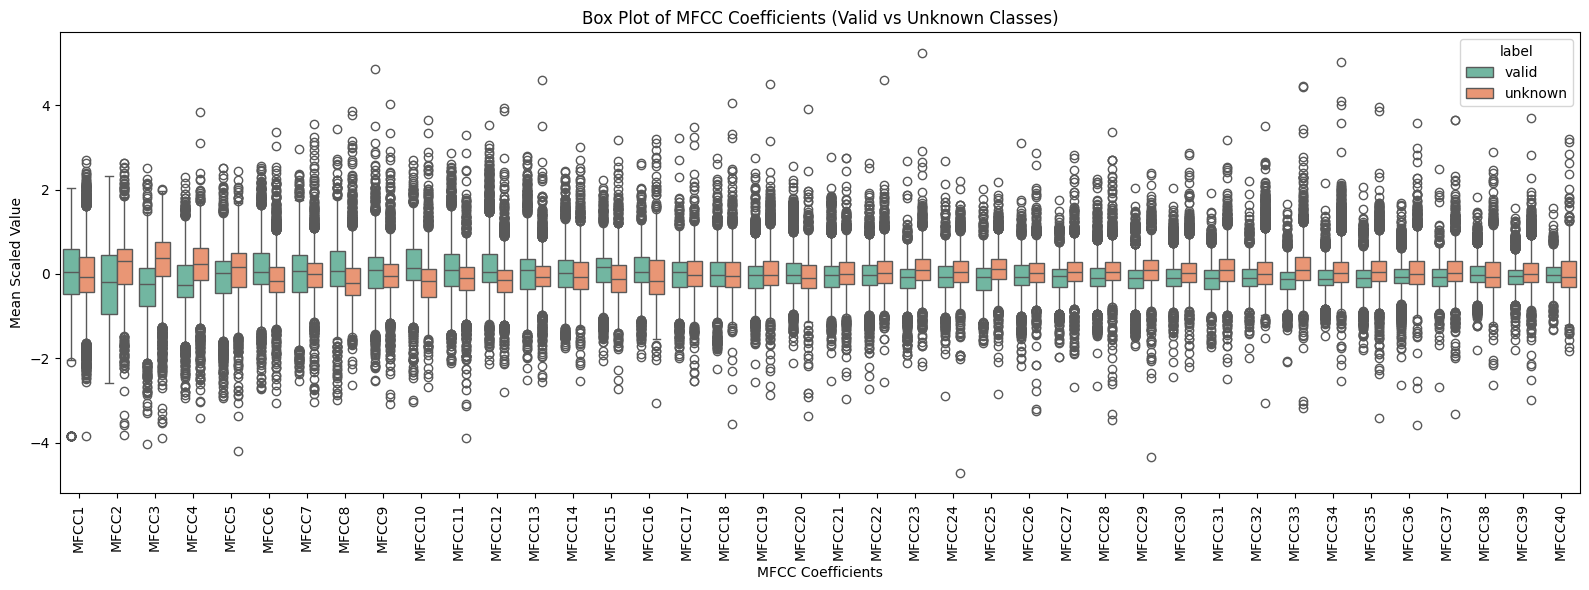

In [19]:
# Convert scaled data back to (num_samples, 100, 40)
X_scaled_reshaped = X_scaled.reshape(X.shape[0], 100, 40)

# Take average over time axis → shape: (num_samples, 40)
mfcc_means = X_scaled_reshaped.mean(axis=1)

# Create DataFrame with class labels
mfcc_df = pd.DataFrame(mfcc_means, columns=[f"MFCC{i+1}" for i in range(40)])
mfcc_df["label"] = labels  # labels should be "valid" or "unknown"

# Melt for Seaborn boxplot
mfcc_melted = mfcc_df.melt(id_vars="label", var_name="MFCC", value_name="Mean Value")

# Plot boxplot grouped by class
plt.figure(figsize=(16, 6))
sns.boxplot(data=mfcc_melted, x="MFCC", y="Mean Value", hue="label", palette="Set2")
plt.title("Box Plot of MFCC Coefficients (Valid vs Unknown Classes)")
plt.xlabel("MFCC Coefficients")
plt.ylabel("Mean Scaled Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


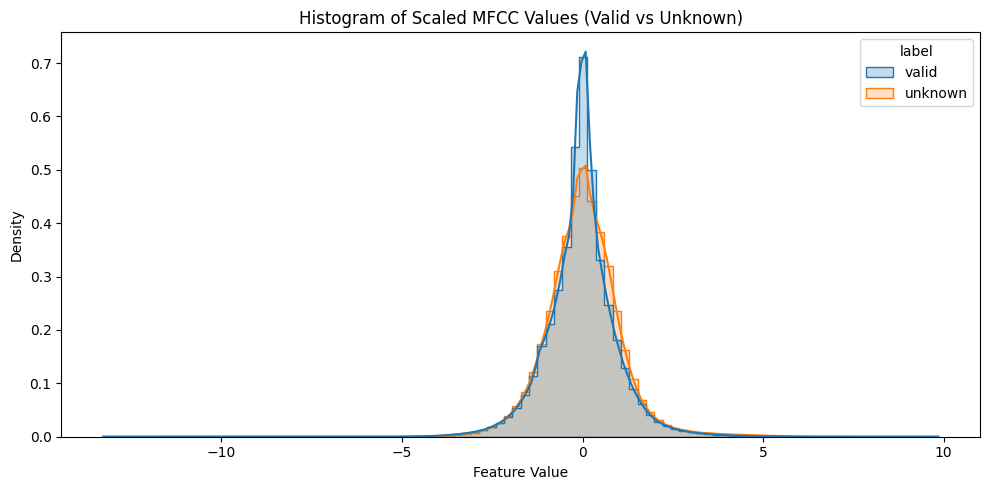

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape scaled data and add class labels
X_scaled_flat = X_scaled.reshape(X.shape[0], -1)  # Shape: (num_samples, 100*40)
df_hist = pd.DataFrame(X_scaled_flat)
df_hist["label"] = labels  # Binary: "valid" or "unknown"

# Melt to long format for Seaborn
df_melted = df_hist.melt(id_vars="label", var_name="feature_index", value_name="value")

# Plot histograms split by class
plt.figure(figsize=(10, 5))
sns.histplot(data=df_melted, x="value", hue="label", bins=100, kde=True, element="step", stat="density", common_norm=False)
plt.title("Histogram of Scaled MFCC Values (Valid vs Unknown)")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


## Train-Test-Split

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

# X_scaled is 2D (num_samples, 100*40), labels is a list or array of "valid"/"unknown"
X_final = X_scaled
y_final = np.array(labels)  # Ensure it's a NumPy array

# Initialize stratified shuffle split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the train/test indices
for train_index, test_index in sss.split(X_final, y_final):
    X_train, X_test = X_final[train_index], X_final[test_index]
    y_train, y_test = y_final[train_index], y_final[test_index]

# Shape check
print("✅ Stratified Split Done")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train distribution: {np.unique(y_train, return_counts=True)}")
print(f"y_test distribution: {np.unique(y_test, return_counts=True)}")


✅ Stratified Split Done
X_train: (5645, 4000), X_test: (1412, 4000)
y_train distribution: (array(['unknown', 'valid'], dtype='<U7'), array([2901, 2744]))
y_test distribution: (array(['unknown', 'valid'], dtype='<U7'), array([726, 686]))


## Model training

In [35]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# 🚫 Suppress warnings (including LightGBM and sklearn)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 🎯 Encode labels ("valid", "unknown") into 0/1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ⚙️ Create LightGBM model with clean params
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_estimators=300,
    learning_rate=0.03,
    max_depth=10,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1
)


# 🏋️ Train the model
model.fit(X_train, y_train_enc)


[LightGBM] [Info] Number of positive: 2744, number of negative: 2901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.315097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020000
[LightGBM] [Info] Number of data points in the train set: 5645, number of used features: 4000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486094 -> initscore=-0.055639
[LightGBM] [Info] Start training from score -0.055639


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03, max_depth=10,
               n_estimators=300, objective='binary', random_state=42,
               reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)

In [36]:
import joblib

# Save the model to a file
joblib.dump(model, "lightgbm_valid_model.pkl")

# Optional: Save label encoder too
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

## Evaluation

In [37]:
# Predict
y_pred = model.predict(X_test)

# Evaluation
print("✅ Model Evaluation")
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\nClassification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))

✅ Model Evaluation
Accuracy: 0.8781869688385269

Classification Report:
               precision    recall  f1-score   support

     unknown       0.94      0.81      0.87       726
       valid       0.83      0.95      0.88       686

    accuracy                           0.88      1412
   macro avg       0.88      0.88      0.88      1412
weighted avg       0.89      0.88      0.88      1412



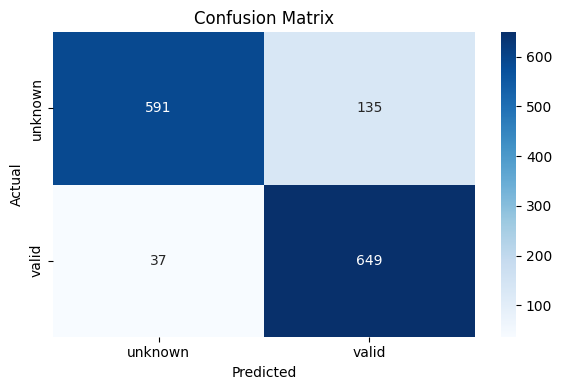

In [38]:

# Confusion Matrix
conf_mat = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import classification_report, f1_score

# Classification report (includes precision, recall, f1, support)
report = classification_report(y_test_enc, y_pred, target_names=le.classes_)
print("📊 Classification Report:\n")
print(report)

# Overall F1 Score (binary)
f1 = f1_score(y_test_enc, y_pred)
print(f"🔍 Overall F1 Score: {f1:.4f}")


📊 Classification Report:

              precision    recall  f1-score   support

     unknown       0.94      0.81      0.87       726
       valid       0.83      0.95      0.88       686

    accuracy                           0.88      1412
   macro avg       0.88      0.88      0.88      1412
weighted avg       0.89      0.88      0.88      1412

🔍 Overall F1 Score: 0.8830


In [40]:
import numpy as np

def classify_validity(audio_file):
    """
    Classifies if the given audio file contains a valid animal sound or is unknown.
    """

    # Extract features
    mfcc = extract_features(audio_file)  # Shape: (100, 40)

    # Reshape and scale like training
    flat = mfcc.reshape(1, -1)
    scaled = scaler.transform(flat)

    # Predict with the LightGBM model
    val_pred = model.predict(scaled)[0]

    # Decode label
    label_name = le.inverse_transform([val_pred])[0]

    # Print result
    if label_name == "unknown":
        print(f"🛑 The audio '{audio_file}' is classified as UNKNOWN (not a valid animal sound).")
    else:
        print(f"✅ The audio '{audio_file}' is classified as VALID (animal sound).")

    return label_name


classify_validity("tp.wav")

🛑 The audio 'tp.wav' is classified as UNKNOWN (not a valid animal sound).


np.str_('unknown')